C:\Users\Lynn\AppData\Local\Temp\ipykernel_5820\2523174103.py:16: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  new_df['Date'] = pd.to_datetime(new_df['Date'])




Epoch 1/1000


Epoch 1: val_loss improved from inf to 0.42211, saving model to best_model.h5
8/8 - 3s - loss: 0.0236 - val_loss: 0.4221 - 3s/epoch - 416ms/step
Epoch 2/1000

Epoch 2: val_loss improved from 0.42211 to 0.36387, saving model to best_model.h5
8/8 - 0s - loss: 0.0178 - val_loss: 0.3639 - 67ms/epoch - 8ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 0.36387 to 0.30632, saving model to best_model.h5
8/8 - 0s - loss: 0.0139 - val_loss: 0.3063 - 69ms/epoch - 9ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 0.30632 to 0.25976, saving model to best_model.h5


c:\Users\Lynn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 - 0s - loss: 0.0119 - val_loss: 0.2598 - 67ms/epoch - 8ms/step
Epoch 5/1000

Epoch 5: val_loss improved from 0.25976 to 0.22900, saving model to best_model.h5
8/8 - 0s - loss: 0.0116 - val_loss: 0.2290 - 71ms/epoch - 9ms/step
Epoch 6/1000

Epoch 6: val_loss improved from 0.22900 to 0.21981, saving model to best_model.h5
8/8 - 0s - loss: 0.0107 - val_loss: 0.2198 - 67ms/epoch - 8ms/step
Epoch 7/1000

Epoch 7: val_loss improved from 0.21981 to 0.20639, saving model to best_model.h5
8/8 - 0s - loss: 0.0097 - val_loss: 0.2064 - 65ms/epoch - 8ms/step
Epoch 8/1000

Epoch 8: val_loss improved from 0.20639 to 0.17804, saving model to best_model.h5
8/8 - 0s - loss: 0.0087 - val_loss: 0.1780 - 62ms/epoch - 8ms/step
Epoch 9/1000

Epoch 9: val_loss improved from 0.17804 to 0.14670, saving model to best_model.h5
8/8 - 0s - loss: 0.0074 - val_loss: 0.1467 - 71ms/epoch - 9ms/step
Epoch 10/1000

Epoch 10: val_loss improved from 0.14670 to 0.10703, saving model to best_model.h5
8/8 - 0s - loss: 0.0

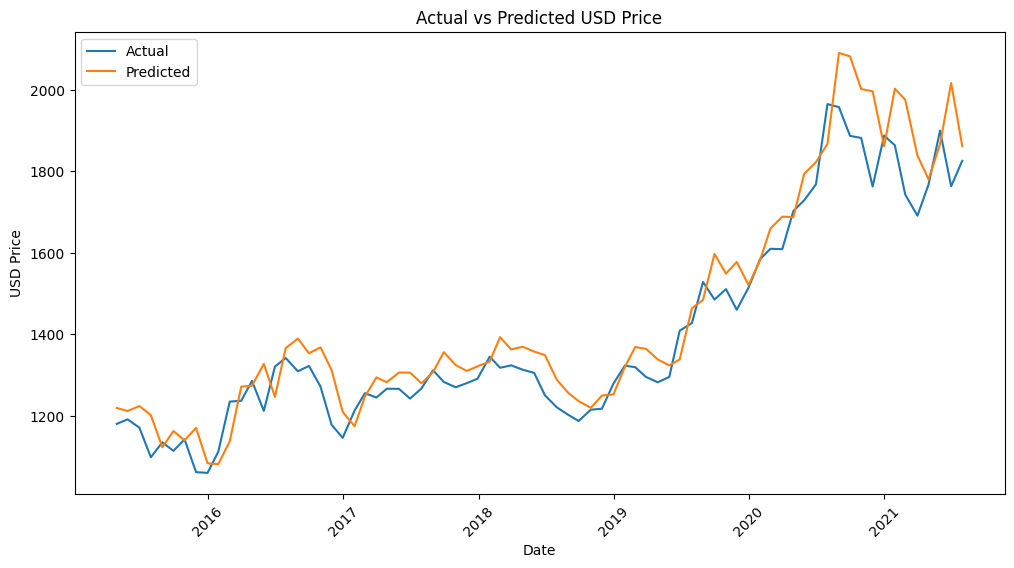

In [1]:
from keras.models import load_model
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt

new_df = pd.read_csv('new_gold.csv')

# Assuming new_df is your DataFrame and it's already preprocessed
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df['Date'] = new_df['Date'].apply(lambda x: x.toordinal())

new_df.set_index('Date', inplace=True)

# Normalize the Dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_df)

# Create the input data and the target variable
X, y = [], []
for i in range(len(scaled_data)-1):
    X.append(scaled_data[i])
    y.append(scaled_data[i + 1])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the LSTM network
model.compile(loss='mean_squared_error', optimizer='adam')

# Create callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Fit the LSTM network with validation split
model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=2, callbacks=[es, mc], validation_split=0.2)

model.save('gold_price.h5')

# Load the best model
best_model = load_model('gold_price.h5')

# Predict on the testing set
y_pred = best_model.predict(X_test)

# Inverse transform the predicted and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Convert Unix epoch to actual dates
y_pred_dates = [datetime.fromordinal(int(date)) for date in new_df.index[-len(y_pred):]]
y_test_dates = [datetime.fromordinal(int(date)) for date in new_df.index[-len(y_test):]]

# Create a dataframe for the predicted and actual values
df_pred = pd.DataFrame({'Date': y_pred_dates, 'USD Price (Predicted)': y_pred.flatten()})
df_actual = pd.DataFrame({'Date': y_test_dates, 'USD Price (Actual)': y_test.flatten()})

# Plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(df_actual['Date'], df_actual['USD Price (Actual)'], label='Actual')
plt.plot(df_pred['Date'], df_pred['USD Price (Predicted)'], label='Predicted')
plt.title('Actual vs Predicted USD Price')
plt.xlabel('Date')
plt.ylabel('USD Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()